In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms

from PIL import Image
from torchvision.utils import make_grid
import os

In [3]:
import sys

sys.path.append("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/")

from adv_manhole.models import load_models, ModelType
from adv_manhole.attack.losses import AdvManholeLosses
from adv_manhole.attack.naturalness import AdvContentLoss
from adv_manhole.texture_mapping.depth_utils import process_surface_coordinates
from adv_manhole.texture_mapping.depth_mapping import DepthTextureMapping

The console stream is logged into /home/carla_client/sg_logs/console.log


[2024-06-03 05:40:21] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


In [4]:
# Load the dataset
carla_dataset = load_dataset("naufalso/carla_hd", cache_dir="/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/")
print(carla_dataset)

filtered_columns_dataset = carla_dataset.select_columns(
    ["rgb", "raw_depth", "camera_config"]
)
print(filtered_columns_dataset)

In [5]:
# Load MonoDepth2 model
monodepth2_model = load_models(ModelType.MDE, "mono_640x192")

# Load DDRNet model
ddrnet_model = load_models(ModelType.SS, "ddrnet_23")

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 532
    })
})
DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 532
    })
})


/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2024-06-03 05:40:34] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the cityscapes dataset, published under the following terms: https:/

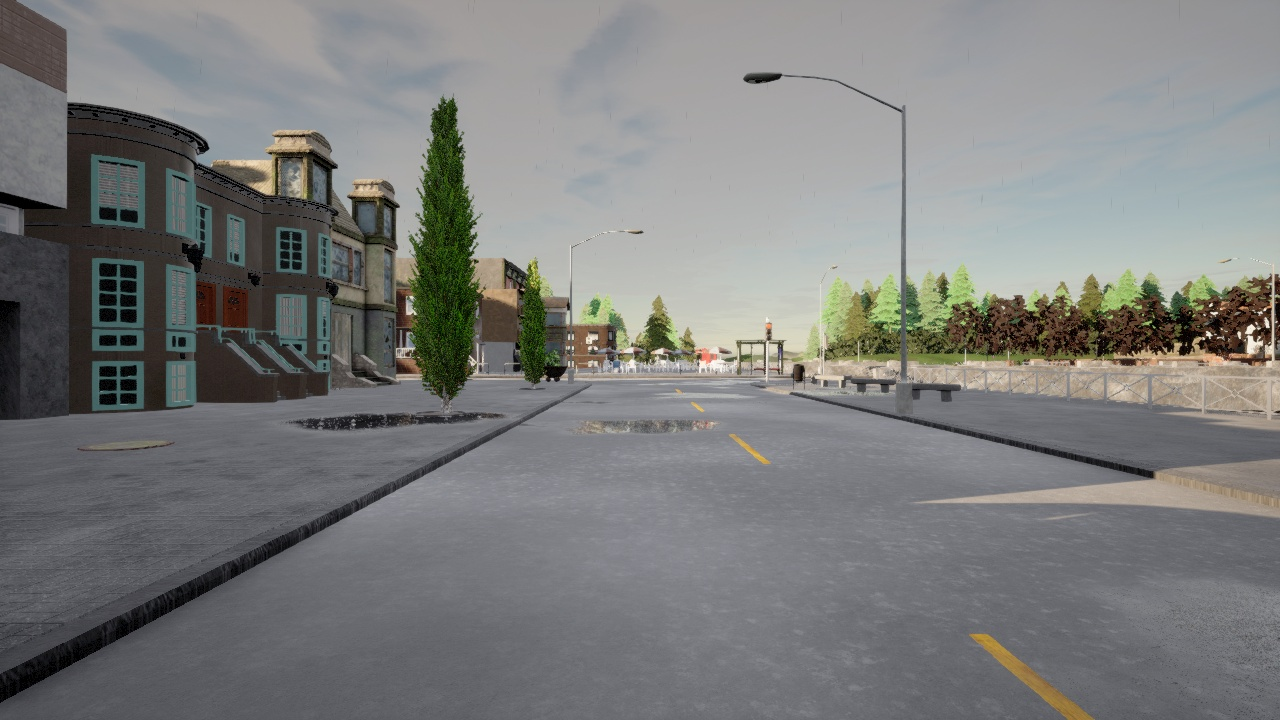

In [6]:
filtered_columns_dataset['train'][2]['rgb']

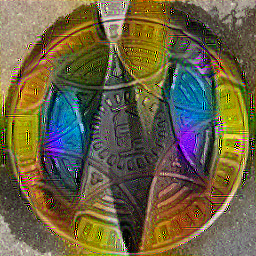

In [7]:
adversarial_manhole = Image.open("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle/texture_epoch_24.png")
adversarial_manhole

In [8]:
depth_planar_mapping = DepthTextureMapping(
    random_scale=(0.0, 0.01),
    with_circle_mask=True,
    device="cuda",
)

In [9]:
device = 'cuda'
rgb = transforms.ToTensor()(filtered_columns_dataset['train'][2]["rgb"]).to(device).unsqueeze(0)
local_surface_coors = transforms.ToTensor()(process_surface_coordinates(filtered_columns_dataset['train'][2]["raw_depth"], filtered_columns_dataset['train'][2]['camera_config'])).to(device).unsqueeze(0)

current_batch_size = rgb.shape[0]

In [10]:
adversarial_manhole_tensor = transforms.ToTensor()(adversarial_manhole).to(device).unsqueeze(0)

In [20]:
final_images, texture_masks = depth_planar_mapping(
    adversarial_manhole_tensor, local_surface_coors, rgb, current_batch_size,
    random_scale=False, random_shift=False
)

print(final_images.shape, texture_masks.shape)

In [21]:
# Predict the depth and semantic segmentation
predicted_disp = monodepth2_model(final_images) #augmented_final_images)
predicted_semantic = ddrnet_model(final_images)

torch.Size([1, 3, 720, 1280]) torch.Size([1, 1, 720, 1280])


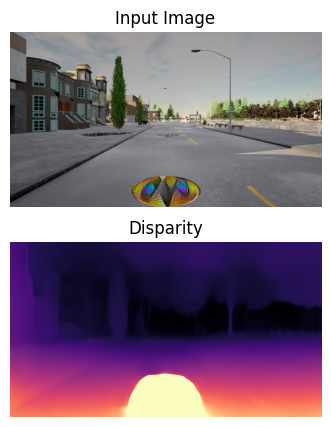

In [22]:
# Plot the depth map
fig = monodepth2_model.plot(final_images[0].detach().cpu().permute(1, 2, 0), predicted_disp[0])
plt.show()

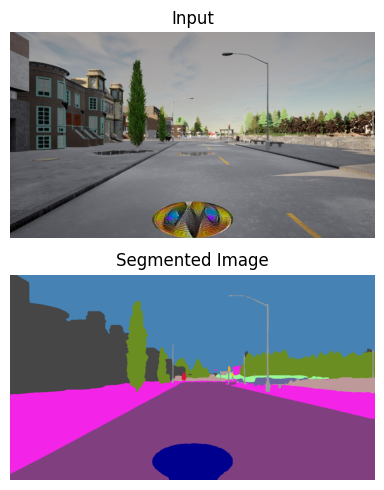

In [23]:
# Plot the semantic segmentation
fig = ddrnet_model.plot(final_images[0].detach().cpu().permute(1, 2, 0), predicted_semantic[0])
plt.show()

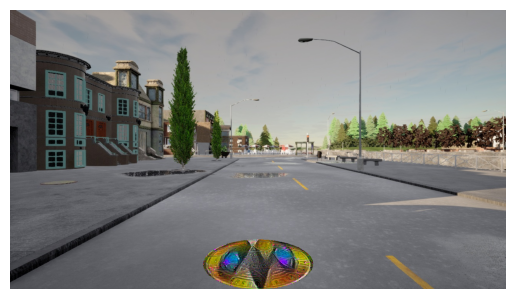

In [24]:
plt.imshow(final_images[0].detach().cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

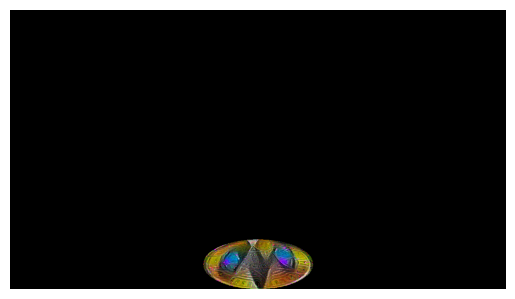

In [28]:
plt.imshow()
plt.axis('off')
plt.show()

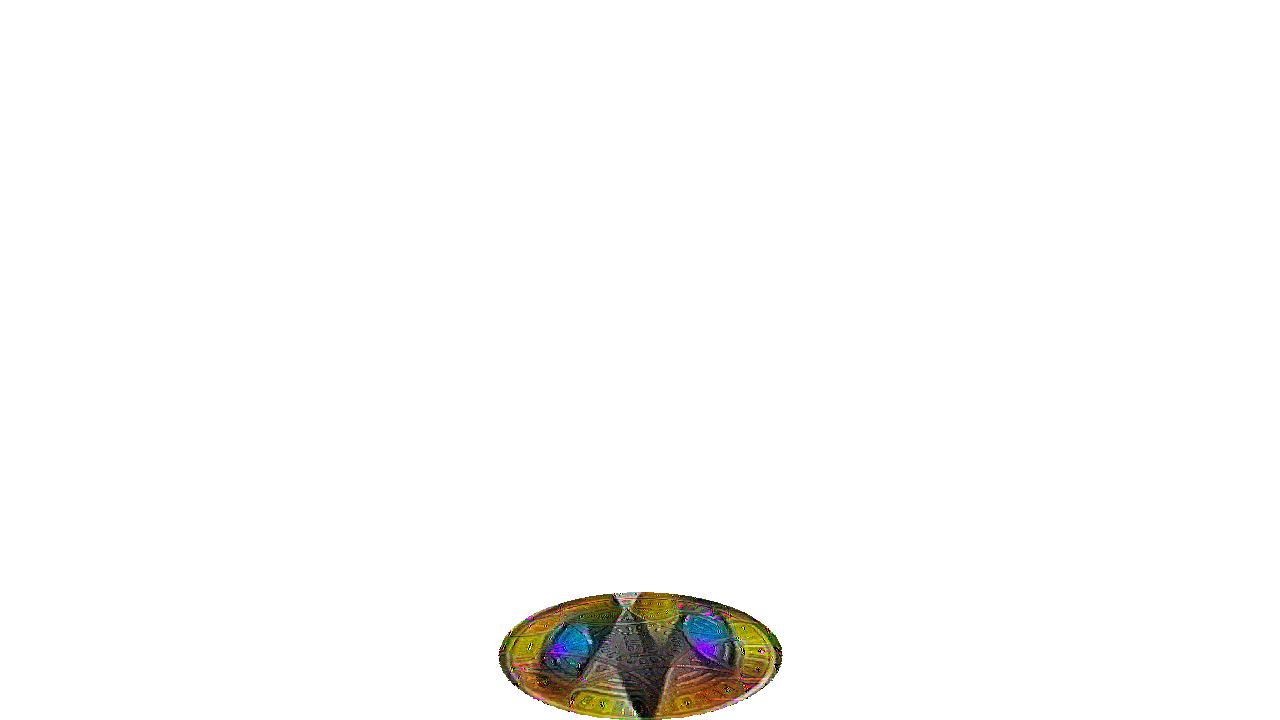

In [30]:
manhole = torch.where(texture_masks[0].repeat(3, 1, 1) > 0.5, final_images[0], 1.0)
transforms.ToPILImage()(manhole.detach().cpu())